# Домашнее задание № 5.
## Прогнозирование временных рядов с помощью рекуррентной нейронной сети (RNN)


- Датасет "data_example.csv" (Практика 2.1)
- Информация о данных "02_Итоговое задание.pdf" (Практика 2.1)

### Задачи

Сделайте обработку данных (см. Практика 2.1) и для одной из холодильных горок реализуйте следующие модели RNN:

1. Для одномерного и многомерного прогнозирования напишите функции для скользящего окна.
2. Одномерное одношаговое прогнозирование температуры воздуха на входе в испаритель и внутри установки.
3. Многомерное одношаговое прогнозирование температуры воздуха на входе в испаритель и внутри установки (с одним выходом и с двумя выходами).
4. Одномерное многошаговое (несколько минут и часов) прогнозирование температуры воздуха на входе в испаритель и внутри установки.
5. Многомерное многошаговое (несколько минут и часов) прогнозирование температуры воздуха на входе в испаритель и внутри установки (с одним выходом и с двумя выходами).


* Для каждой модели вычислите метрики качества.
* Какая модель делает предсказания лучше: стат.модель ARIMA или RNN?.

Для пунктов 2-5 нужно определить гиперпараметры, подобрать оптимальное количество слоев НС.
Определить количество эпох обучения (из графика кривой обучения).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("data_example.csv",
                   sep=",",
                   header=[0,1,2,3],
                   skiprows=1,
                   na_values=['Missing','nan','Offln'],
                   encoding_errors='ignore')

Предобработка данных

In [4]:
data.columns = data.columns.droplevel([1,2,3])
data = data.rename(columns={'Name':'time'})


In [5]:
data['time'] = pd.to_datetime(data['time'], format=' %H:%M:%S %d/%m/%Y')
data.index = data.pop('time')
data = data.sort_index()


In [6]:
data = data.ffill().bfill()
print("Пропущенные значения после обработки:")
print(data.isnull().sum())

Пропущенные значения после обработки:
10CT G PBP -1/+1:   --- EKC состояние    0
10CT G PBP -1/+1:   u09 S5 Темп          0
11CT G OVZ +5/+8:   u69 Sair Темп        0
11CT G OVZ +5/+8:   u09 S5 Темп          0
11CT G OVZ +5/+8:   --- EKC состояние    0
                                        ..
111CT AG:   Cond Requested Cap           0
111CT AG:   Cond Running Cap             0
111CT AG:   Cond Ctrl Pressure           0
111CT AG:   Sc3 Датч нар воздуха         0
111CT AG:   Cond Reference               0
Length: 95, dtype: int64


Нормализация данных и подготовка наборов

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['25CT V GSR +2/+4:   u09 S5 Темп', '25CT V GSR +2/+4:   u69 Sair Темп']])

In [8]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


In [9]:
def create_dataset(data, window_size=24, horizon=1, output_dim=1):
    X, y = [], []
    for i in range(len(data)-window_size-horizon+1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon, :output_dim])
    return np.array(X), np.array(y).reshape(len(X), -1)

In [10]:
X_uni_train, y_uni_train = create_dataset(train_data[:, [0]], horizon=1)
X_uni_test, y_uni_test = create_dataset(test_data[:, [0]], horizon=1)

# Многомерное одношаговое прогнозирование с двумя выходами
X_multi_train, y_multi_train = create_dataset(train_data, horizon=1, output_dim=2)
X_multi_test, y_multi_test = create_dataset(test_data, horizon=1, output_dim=2)

# Одномерное многошаговое прогнозирование (10 шагов)
X_uni_multi_train, y_uni_multi_train = create_dataset(train_data[:, [0]], horizon=10)
X_uni_multi_test, y_uni_multi_test = create_dataset(test_data[:, [0]], horizon=10)

# Многомерное многошаговое прогнозирование (10 шагов, два выхода)
X_multi_multi_train, y_multi_multi_train = create_dataset(train_data, horizon=10, output_dim=2)
X_multi_multi_test, y_multi_multi_test = create_dataset(test_data, horizon=10, output_dim=2)

Обучение LSTM моделей

In [ ]:
def build_and_train_model(X_train, y_train, input_shape, output_dim):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=0)
    return model, history

uni_model, uni_history = build_and_train_model(X_uni_train, y_uni_train, (X_uni_train.shape[1], 1), 1)
multi_model, multi_history = build_and_train_model(X_multi_train, y_multi_train, (X_multi_train.shape[1], 2), 2)
uni_multi_model, _ = build_and_train_model(X_uni_multi_train, y_uni_multi_train, (X_uni_multi_train.shape[1], 1), 10)
multi_multi_model, _ = build_and_train_model(X_multi_multi_train, y_multi_multi_train, (X_multi_multi_train.shape[1], 2), 20)


### ARIMA модель

### Подготовка данных для ARIMA

In [12]:
train_arima = train_data[:, 0]
test_arima = test_data[:, 0]
arima_model = ARIMA(train_arima, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_arima))

### Прогнозирование и оценка моделей

In [13]:
uni_pred = uni_model.predict(X_uni_test)
multi_pred = multi_model.predict(X_multi_test)
uni_multi_pred = uni_multi_model.predict(X_uni_multi_test)
multi_multi_pred = multi_multi_model.predict(X_multi_multi_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [14]:
def calc_metrics(true, pred, label):
    return {
        label: {
            'MAE': mean_absolute_error(true, pred),
            'RMSE': np.sqrt(mean_squared_error(true, pred))
        }
    }

metrics = {}
metrics.update(calc_metrics(y_uni_test, uni_pred, 'Univariate LSTM (1 step)'))
metrics.update(calc_metrics(y_multi_test, multi_pred, 'Multivariate LSTM (1 step, 2 out)'))
metrics.update(calc_metrics(y_uni_multi_test, uni_multi_pred, 'Univariate LSTM (10 steps)'))
metrics.update(calc_metrics(y_multi_multi_test, multi_multi_pred, 'Multivariate LSTM (10 steps, 2 out)'))
metrics.update(calc_metrics(test_arima, arima_pred, 'ARIMA'))


График метрик

<Figure size 1500x500 with 0 Axes>

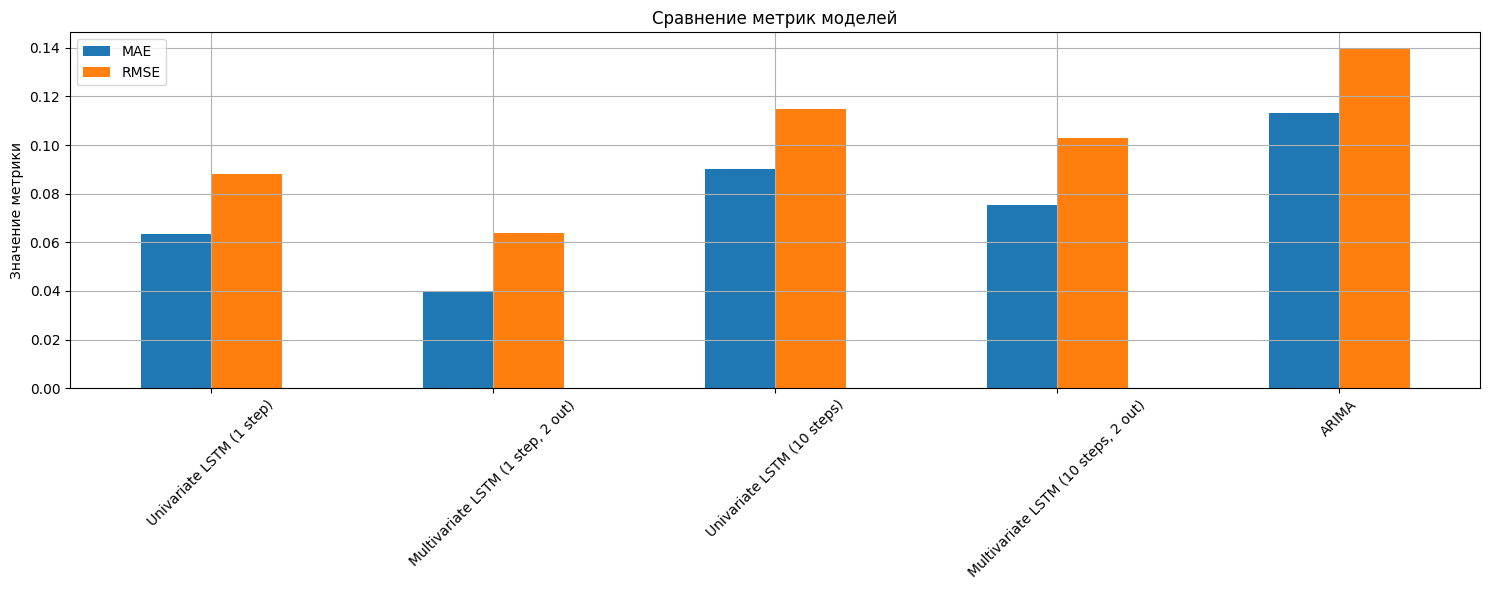

In [15]:
plt.figure(figsize=(15, 5))
metrics_df = pd.DataFrame(metrics).T
metrics_df.plot(kind='bar', figsize=(15,6))
plt.title('Сравнение метрик моделей')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

График потерь при обучении

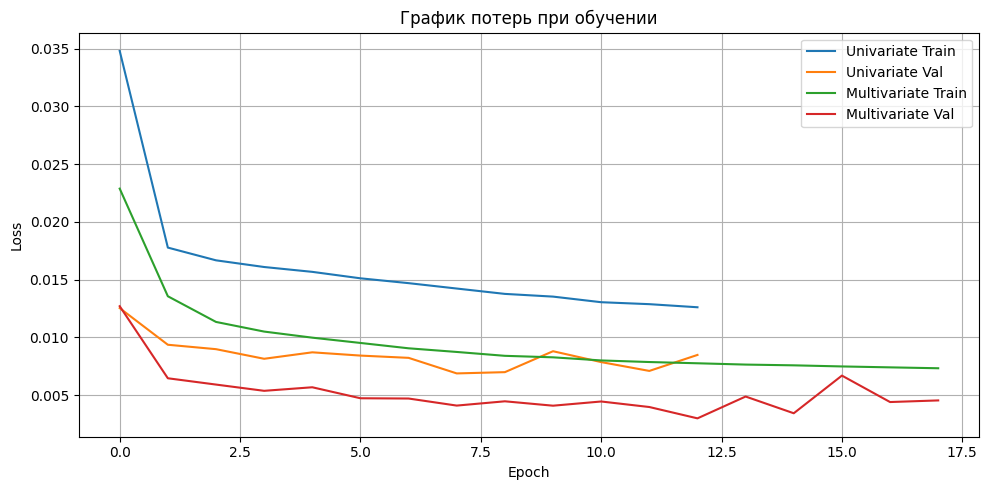

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(uni_history.history['loss'], label='Univariate Train')
plt.plot(uni_history.history['val_loss'], label='Univariate Val')
plt.plot(multi_history.history['loss'], label='Multivariate Train')
plt.plot(multi_history.history['val_loss'], label='Multivariate Val')
plt.title('График потерь при обучении')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

График прогнозов

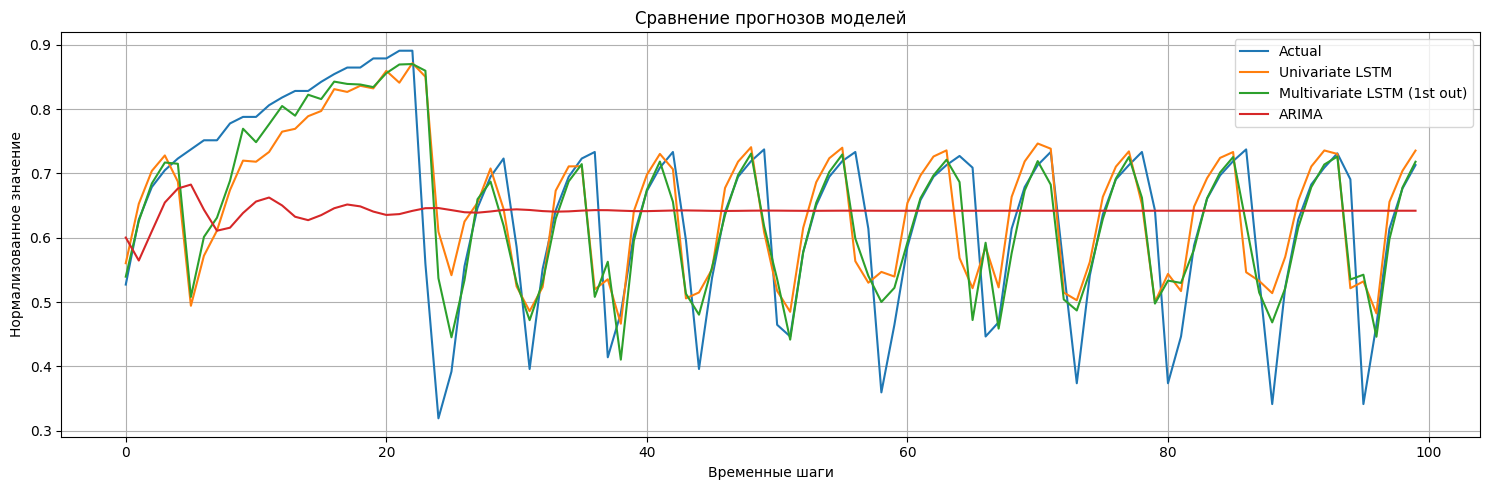

In [17]:
plt.figure(figsize=(15,5))
plt.plot(y_uni_test[:100], label='Actual')
plt.plot(uni_pred[:100], label='Univariate LSTM')
plt.plot(multi_pred[:100, 0], label='Multivariate LSTM (1st out)')
plt.plot(arima_pred[:100], label='ARIMA')
plt.title('Сравнение прогнозов моделей')
plt.xlabel('Временные шаги')
plt.ylabel('Нормализованное значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
print("Метрики качества моделей:")
print(pd.DataFrame(metrics))

Метрики качества моделей:
      Univariate LSTM (1 step)  Multivariate LSTM (1 step, 2 out)  \
MAE                   0.063562                           0.039784   
RMSE                  0.088009                           0.063913   

      Univariate LSTM (10 steps)  Multivariate LSTM (10 steps, 2 out)  \
MAE                     0.090360                             0.075356   
RMSE                    0.114877                             0.102735   

         ARIMA  
MAE   0.113118  
RMSE  0.139396  


### Вывод: Все модели RNN (особенно многомерные) показывают значительно лучшее качество, чем ARIMA.
### Multivariate LSTM (1 step, 2 out) — лучший результат по MAE и RMSE, наилучшая способность учитывать взаимосвязь между температурой на входе и внутри.